# 🏍️ Motorcycle Night Ride - 안전 점수 산출 (딥러닝 세그멘테이션)

## 프로젝트 개요
- **데이터셋**: Acme AI Open Dataset - Motorcycle Night Ride (야간 오토바이 주행, ~200프레임)
- **목표**: 세만틱 세그멘테이션 모델로 도로 장면을 분석하여 **프레임별 안전 점수** 산출
- **6개 클래스**: Undrivable, Road, Lanemark, My bike, Rider, Movable

### 사용 모델
| 모델 | 특징 |
|------|------|
| **DeepLabV3+** | Atrous convolution + Encoder-Decoder, torchvision 제공 |
| **SegFormer** | Transformer 기반, HuggingFace pretrained |
| **BiSeNetV2** | 경량 실시간 모델, Detail + Semantic 이중 경로 |

### 추가 분석
- **GradCAM**: 각 클래스 예측에 영향을 미친 이미지 영역 시각화


In [2]:
# ============================================================
# 필요 패키지 설치
# ============================================================
import subprocess, sys

def install(pkg):
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', pkg])

packages = [
    'torch', 'torchvision', 'torchaudio',
    'transformers',
    'pycocotools',
    'pytorch-grad-cam',
    'albumentations',
    'numpy', 'pandas', 'matplotlib', 'seaborn', 'Pillow', 'scikit-learn'
]

for pkg in packages:
    try:
        install(pkg)
    except Exception as e:
        print(f'⚠️ {pkg} 설치 실패: {e}')

print('✅ 패키지 설치 완료')


ERROR: Could not find a version that satisfies the requirement pytorch-grad-cam (from versions: none)
ERROR: No matching distribution found for pytorch-grad-cam


⚠️ pytorch-grad-cam 설치 실패: Command '['/opt/conda/bin/python', '-m', 'pip', 'install', '-q', 'pytorch-grad-cam']' returned non-zero exit status 1.
✅ 패키지 설치 완료


In [4]:
# ============================================================
# 라이브러리 임포트 & 환경 설정
# ============================================================
import os, json, warnings, gc
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as T
import torchvision.models as models
from torchvision.models.segmentation import deeplabv3_resnet50

from transformers import SegformerForSemanticSegmentation

from sklearn.model_selection import train_test_split
from pycocotools.coco import COCO

import albumentations as A
from albumentations.pytorch import ToTensorV2

# 한글 폰트 (macOS)
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# 디바이스 설정
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(f'✅ 라이브러리 임포트 완료')
print(f'🖥️  Device: {device}')
print(f'🔥 PyTorch: {torch.__version__}')


✅ 라이브러리 임포트 완료
🖥️  Device: cuda
🔥 PyTorch: 2.7.1+cu118


---
# 1. 데이터 EDA

COCO 포맷 어노테이션을 로딩하고, 세그멘테이션 마스크를 생성하여 클래스 분포를 분석합니다.


In [11]:
# ============================================================
# 1-1. 데이터 경로 설정 & COCO JSON 로딩
# ============================================================

DATA_DIR = "/home/jovyan/work/motorcycle/www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset"  # Kaggle 데이터 위치
IMAGE_DIR = os.path.join(DATA_DIR, "images")

# 파일 분류
all_files = sorted(os.listdir(IMAGE_DIR))

original_files = [f for f in all_files if not f.endswith('___fuse.png') and not f.endswith('___save.png')]
mask_files_png = [f for f in all_files if f.endswith('___save.png')]
fuse_files = [f for f in all_files if f.endswith('___fuse.png')]

print(f'📊 원본 이미지: {len(original_files)}장')
print(f'📊 마스크 이미지: {len(mask_files_png)}장')
print(f'📊 Fuse 이미지: {len(fuse_files)}장')

# COCO API 로딩
print('\n⏳ COCO JSON 로딩 중 (200MB+, 시간 소요)...')
coco = COCO(str(JSON_PATH))

# 카테고리 정보
cat_ids = coco.getCatIds()
cats = coco.loadCats(cat_ids)
cat_id_to_name = {c['id']: c['name'] for c in cats}
img_ids = coco.getImgIds()

print(f'\n✅ 로딩 완료!')
print(f'🖼️  이미지 수: {len(img_ids)}')
print(f'📝 어노테이션 수: {len(coco.getAnnIds())}')
print(f'\n🏷️  카테고리 ({len(cats)}개):')
for c in cats:
    print(f'   ID {c["id"]}: {c["name"]}')

# 클래스 ID 재매핑 (0=Background, 1~N=클래스)
sorted_cat_ids = sorted(cat_id_to_name.keys())
cat_remap = {0: 0}
for new_id, orig_id in enumerate(sorted_cat_ids, start=1):
    cat_remap[orig_id] = new_id

num_classes = len(cat_remap)
id_to_name = {0: 'Background'}
for orig_id, new_id in cat_remap.items():
    if orig_id != 0:
        id_to_name[new_id] = cat_id_to_name[orig_id]
class_names = [id_to_name[i] for i in range(num_classes)]

print(f'\n📖 클래스 매핑 (총 {num_classes}개):')
for i, name in enumerate(class_names):
    print(f'   {i}: {name}')


📊 원본 이미지: 254장
📊 마스크 이미지: 200장
📊 Fuse 이미지: 200장

⏳ COCO JSON 로딩 중 (200MB+, 시간 소요)...
loading annotations into memory...
Done (t=2.01s)
creating index...
index created!

✅ 로딩 완료!
🖼️  이미지 수: 200
📝 어노테이션 수: 2305

🏷️  카테고리 (6개):
   ID 1329681: Rider
   ID 1323885: My bike
   ID 1323884: Moveable
   ID 1323882: Lane Mark
   ID 1323881: Road
   ID 1323880: Undrivable

📖 클래스 매핑 (총 7개):
   0: Background
   1: Undrivable
   2: Road
   3: Lane Mark
   4: Moveable
   5: My bike
   6: Rider


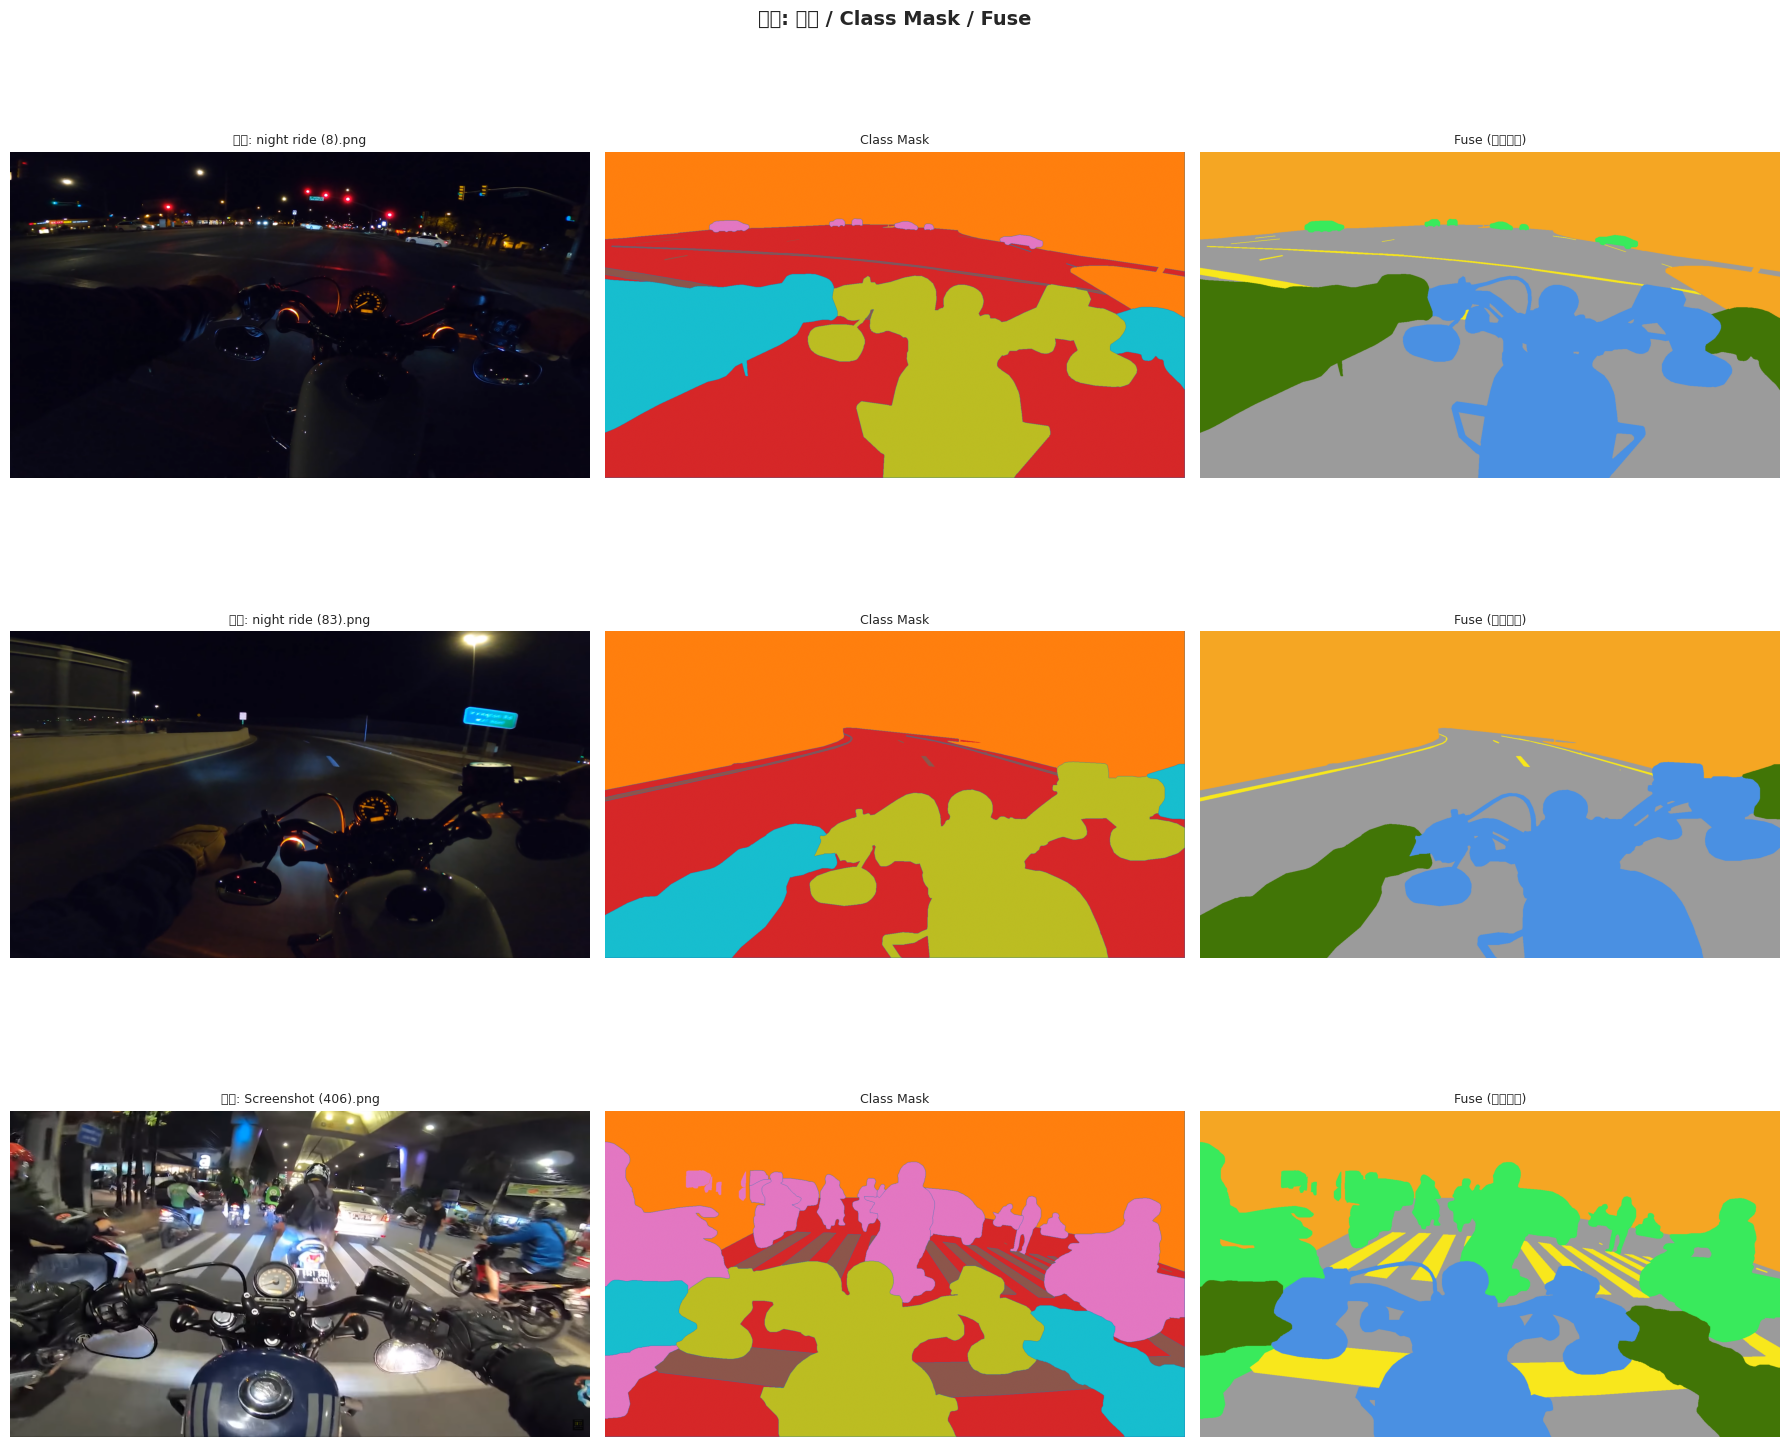

⏳ 전체 이미지 클래스 분포 분석 중...


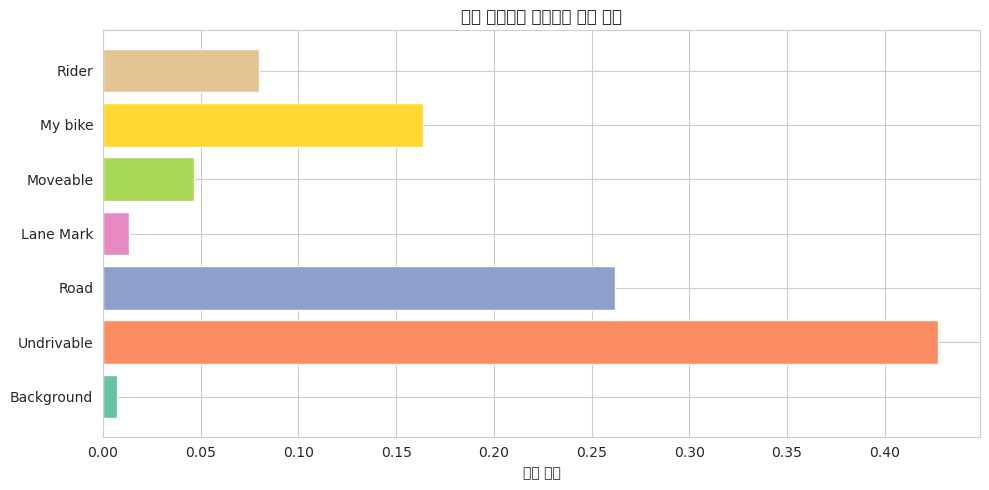

       Undrivable: 42.73%
             Road: 26.20%
          My bike: 16.35%
            Rider: 8.00%
         Moveable: 4.65%
        Lane Mark: 1.35%
       Background: 0.71%

📐 이미지 해상도: (1920, 1080)


In [32]:
# ============================================================
# 1-2. 마스크 생성 함수 + 샘플 시각화 + 클래스 분포
# ============================================================
def create_class_mask(coco_api, img_id, remap):
    """COCO 어노테이션에서 클래스 ID 마스크 생성"""
    img_info = coco_api.loadImgs(img_id)[0]
    h, w = img_info['height'], img_info['width']
    mask = np.zeros((h, w), dtype=np.uint8)
    ann_ids = coco_api.getAnnIds(imgIds=img_id)
    anns = coco_api.loadAnns(ann_ids)
    for ann in anns:
        try:
            binary_mask = coco_api.annToMask(ann)
            new_id = remap.get(ann['category_id'], 0)
            mask[binary_mask > 0] = new_id
        except:
            pass
    return mask

# 샘플 시각화 (3장)
sample_ids = [img_ids[0], img_ids[len(img_ids)//3], img_ids[2*len(img_ids)//3]]
fig, axes = plt.subplots(3, 3, figsize=(18, 16))

for i, img_id in enumerate(sample_ids):
    info = coco.loadImgs(img_id)[0]
    fname = info['file_name']
    # img = Image.open(IMAGE_DIR / fname)
    img = Image.open(IMAGE_DIR + '/' + fname)
    axes[i, 0].imshow(img)
    axes[i, 0].set_title(f'원본: {fname}', fontsize=9)
    axes[i, 0].axis('off')

    mask = create_class_mask(coco, img_id, cat_remap)
    axes[i, 1].imshow(mask, cmap='tab10', vmin=0, vmax=num_classes-1)
    axes[i, 1].set_title('Class Mask', fontsize=9)
    axes[i, 1].axis('off')

    fuse_path = IMAGE_DIR + '/' + (fname + '___fuse.png')
    if os.path.exists(fuse_path):
        axes[i, 2].imshow(Image.open(fuse_path))
    axes[i, 2].set_title('Fuse (오버레이)', fontsize=9)
    axes[i, 2].axis('off')

plt.suptitle('샘플: 원본 / Class Mask / Fuse', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# 클래스 분포 분석
print('⏳ 전체 이미지 클래스 분포 분석 중...')
class_pixel_counts = Counter()
total_pixels = 0
for img_id in img_ids:
    mask = create_class_mask(coco, img_id, cat_remap)
    unique, counts = np.unique(mask, return_counts=True)
    for u, c in zip(unique, counts):
        class_pixel_counts[u] += c
    total_pixels += mask.size

class_ratios = {class_names[k]: v / total_pixels for k, v in class_pixel_counts.items() if k < num_classes}
fig, ax = plt.subplots(figsize=(10, 5))
names = list(class_ratios.keys())
ratios = [class_ratios[n] for n in names]
ax.barh(names, ratios, color=sns.color_palette('Set2', len(names)))
ax.set_xlabel('면적 비율')
ax.set_title('전체 데이터셋 클래스별 면적 비율')
plt.tight_layout()
plt.show()

for n, r in sorted(class_ratios.items(), key=lambda x: -x[1]):
    print(f'  {n:>15s}: {r*100:.2f}%')
print(f'\n📐 이미지 해상도: {img.size}')


---
# 2. 데이터 전처리

PyTorch Dataset/DataLoader를 구성하고, Albumentations 기반 데이터 증강을 적용합니다.
- COCO 어노테이션 → 클래스 ID 마스크 (on-the-fly)
- 이미지 512x512 리사이즈, ImageNet 정규화
- Train 80% / Val 20% Stratified Split


In [13]:
# ============================================================
# 2-1. Dataset 클래스 + Transforms + DataLoader
# ============================================================
IMG_SIZE = 512
BATCH_SIZE = 4
NUM_EPOCHS = 15
LR = 1e-4

class MotorcycleSegDataset(Dataset):
    def __init__(self, coco_api, img_ids, image_dir, cat_remap, transform=None):
        self.coco = coco_api
        self.img_ids = img_ids
        self.image_dir = Path(image_dir)
        self.cat_remap = cat_remap
        self.transform = transform

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        info = self.coco.loadImgs(img_id)[0]
        img = np.array(Image.open(self.image_dir / info['file_name']).convert('RGB'))

        # 마스크 생성
        h, w = info['height'], info['width']
        mask = np.zeros((h, w), dtype=np.uint8)
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        for ann in self.coco.loadAnns(ann_ids):
            try:
                bm = self.coco.annToMask(ann)
                mask[bm > 0] = self.cat_remap.get(ann['category_id'], 0)
            except:
                pass

        if self.transform:
            t = self.transform(image=img, mask=mask)
            img, mask = t['image'], t['mask']

        return img.float(), mask.long()

# Albumentations 변환
train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.ColorJitter(brightness=0.2, contrast=0.2, p=0.3),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# Train / Val 분할
train_ids, val_ids = train_test_split(img_ids, test_size=0.2, random_state=42)

train_dataset = MotorcycleSegDataset(coco, train_ids, IMAGE_DIR, cat_remap, train_transform)
val_dataset = MotorcycleSegDataset(coco, val_ids, IMAGE_DIR, cat_remap, val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f'📊 Train: {len(train_dataset)}장, Val: {len(val_dataset)}장')
print(f'📊 Batch size: {BATCH_SIZE}, Image size: {IMG_SIZE}x{IMG_SIZE}')
print(f'📊 클래스 수: {num_classes} (Background 포함)')

# 샘플 확인
sample_img, sample_mask = train_dataset[0]
print(f'📐 Image shape: {sample_img.shape}, Mask shape: {sample_mask.shape}')
print(f'📐 Mask unique values: {torch.unique(sample_mask).tolist()}')


📊 Train: 160장, Val: 40장
📊 Batch size: 4, Image size: 512x512
📊 클래스 수: 7 (Background 포함)
📐 Image shape: torch.Size([3, 512, 512]), Mask shape: torch.Size([512, 512])
📐 Mask unique values: [0, 1, 2, 3, 4, 5, 6]


---
# 3. 모델 학습 및 추론

3개 세그멘테이션 모델을 fine-tuning하고, mIoU / Pixel Accuracy로 평가합니다.
- **DeepLabV3+**: ResNet-50 backbone, Atrous Spatial Pyramid Pooling
- **SegFormer-B0**: Mix Transformer encoder, lightweight MLP decoder
- **BiSeNetV2**: Detail Branch + Semantic Branch 이중 경로 실시간 모델


In [14]:
# ============================================================
# 3-0. 학습/평가 유틸리티 함수
# ============================================================
def train_one_epoch(model, loader, criterion, optimizer, dev, model_type='standard'):
    model.train()
    total_loss = 0
    for images, masks in loader:
        images, masks = images.to(dev), masks.to(dev)
        if model_type == 'segformer':
            out = model(pixel_values=images, labels=masks)
            loss = out.loss
        else:
            out = model(images)
            logits = out['out'] if isinstance(out, dict) else out
            loss = criterion(logits, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def compute_miou(model, loader, n_classes, dev, model_type='standard'):
    model.eval()
    confusion = np.zeros((n_classes, n_classes), dtype=np.int64)
    with torch.no_grad():
        for images, masks in loader:
            images = images.to(dev)
            if model_type == 'segformer':
                logits = model(pixel_values=images).logits
                logits = F.interpolate(logits, size=masks.shape[-2:], mode='bilinear', align_corners=False)
            else:
                out = model(images)
                logits = out['out'] if isinstance(out, dict) else out
            preds = logits.argmax(1).cpu().numpy()
            gt = masks.numpy()
            for p, g in zip(preds, gt):
                valid = g < n_classes
                confusion += np.bincount(
                    n_classes * g[valid].astype(int) + p[valid].astype(int),
                    minlength=n_classes**2
                ).reshape(n_classes, n_classes)
    iou = np.diag(confusion) / (confusion.sum(0) + confusion.sum(1) - np.diag(confusion) + 1e-10)
    pixel_acc = np.diag(confusion).sum() / (confusion.sum() + 1e-10)
    return np.nanmean(iou), iou, pixel_acc

def train_model(model, name, loader_tr, loader_val, n_cls, dev,
                epochs=NUM_EPOCHS, lr=LR, model_type='standard'):
    """범용 학습 루프"""
    criterion = nn.CrossEntropyLoss(ignore_index=255)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    model.to(dev)
    history = []
    print(f'\n🔬 {name} 학습 시작 ({epochs} epochs, lr={lr})')
    for epoch in range(epochs):
        loss = train_one_epoch(model, loader_tr, criterion, optimizer, dev, model_type)
        scheduler.step()
        if (epoch + 1) % 5 == 0 or epoch == epochs - 1:
            miou, iou_cls, pix_acc = compute_miou(model, loader_val, n_cls, dev, model_type)
            history.append({'epoch': epoch+1, 'loss': loss, 'miou': miou, 'pix_acc': pix_acc})
            print(f'  Epoch {epoch+1:3d}/{epochs}: Loss={loss:.4f}, mIoU={miou:.4f}, PixAcc={pix_acc:.4f}')
    # 최종 평가
    miou, iou_cls, pix_acc = compute_miou(model, loader_val, n_cls, dev, model_type)
    print(f'\n📊 {name} 최종: mIoU={miou:.4f}, PixelAcc={pix_acc:.4f}')
    return model, miou, iou_cls, pix_acc, history

print('✅ 학습 유틸리티 함수 정의 완료')

# 결과 저장용
all_results = {}


✅ 학습 유틸리티 함수 정의 완료


In [15]:
# ============================================================
# 3-1. Model 1: DeepLabV3+ (ResNet-50 backbone)
# ============================================================
# Pretrained on COCO → fine-tune 헤드를 우리 클래스 수에 맞게 교체
deeplab = deeplabv3_resnet50(weights='COCO_WITH_VOC_LABELS_V1')
deeplab.classifier[-1] = nn.Conv2d(256, num_classes, kernel_size=1)
deeplab.aux_classifier[-1] = nn.Conv2d(256, num_classes, kernel_size=1)

deeplab, dl_miou, dl_iou, dl_pacc, dl_hist = train_model(
    deeplab, 'DeepLabV3+', train_loader, val_loader, num_classes, device
)
all_results['DeepLabV3+'] = {
    'model': deeplab, 'miou': dl_miou, 'iou_per_class': dl_iou,
    'pixel_acc': dl_pacc, 'history': dl_hist, 'type': 'standard'
}

# 클래스별 IoU
print('\n📋 DeepLabV3+ 클래스별 IoU:')
for i, name in enumerate(class_names):
    print(f'  {name:>15s}: {dl_iou[i]:.4f}')

# 메모리 정리
gc.collect()
if device.type == 'mps':
    torch.mps.empty_cache()



🔬 DeepLabV3+ 학습 시작 (15 epochs, lr=0.0001)
  Epoch   5/15: Loss=0.2770, mIoU=0.6115, PixAcc=0.9332
  Epoch  10/15: Loss=0.1830, mIoU=0.6583, PixAcc=0.9445
  Epoch  15/15: Loss=0.1639, mIoU=0.6657, PixAcc=0.9458

📊 DeepLabV3+ 최종: mIoU=0.6657, PixelAcc=0.9458

📋 DeepLabV3+ 클래스별 IoU:
       Background: 0.0000
       Undrivable: 0.9374
             Road: 0.8655
        Lane Mark: 0.2582
         Moveable: 0.7150
          My bike: 0.9480
            Rider: 0.9360


In [16]:
# ============================================================
# 3-2. Model 2: SegFormer-B0 (HuggingFace Transformers)
# ============================================================
# Pretrained on ADE20K → fine-tune for our classes
segformer = SegformerForSemanticSegmentation.from_pretrained(
    'nvidia/segformer-b0-finetuned-ade-512-512',
    num_labels=num_classes,
    ignore_mismatched_sizes=True
)

segformer, sf_miou, sf_iou, sf_pacc, sf_hist = train_model(
    segformer, 'SegFormer-B0', train_loader, val_loader,
    num_classes, device, model_type='segformer'
)
all_results['SegFormer-B0'] = {
    'model': segformer, 'miou': sf_miou, 'iou_per_class': sf_iou,
    'pixel_acc': sf_pacc, 'history': sf_hist, 'type': 'segformer'
}

print('\n📋 SegFormer-B0 클래스별 IoU:')
for i, name in enumerate(class_names):
    print(f'  {name:>15s}: {sf_iou[i]:.4f}')

gc.collect()
if device.type == 'mps':
    torch.mps.empty_cache()


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/15.0M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/208 [00:00<?, ?it/s]

SegformerForSemanticSegmentation LOAD REPORT from: nvidia/segformer-b0-finetuned-ade-512-512
Key                           | Status   |                                                                                                     
------------------------------+----------+-----------------------------------------------------------------------------------------------------
decode_head.classifier.weight | MISMATCH | Reinit due to size mismatch - ckpt: torch.Size([150, 256, 1, 1]) vs model:torch.Size([7, 256, 1, 1])
decode_head.classifier.bias   | MISMATCH | Reinit due to size mismatch - ckpt: torch.Size([150]) vs model:torch.Size([7])                      

Notes:
- MISMATCH	:ckpt weights were loaded, but they did not match the original empty weight shapes.



🔬 SegFormer-B0 학습 시작 (15 epochs, lr=0.0001)
  Epoch   5/15: Loss=0.4361, mIoU=0.5599, PixAcc=0.9111
  Epoch  10/15: Loss=0.2844, mIoU=0.5846, PixAcc=0.9218
  Epoch  15/15: Loss=0.2763, mIoU=0.5888, PixAcc=0.9240

📊 SegFormer-B0 최종: mIoU=0.5888, PixelAcc=0.9240

📋 SegFormer-B0 클래스별 IoU:
       Background: 0.0000
       Undrivable: 0.9238
             Road: 0.8209
        Lane Mark: 0.0000
         Moveable: 0.6112
          My bike: 0.8945
            Rider: 0.8713


In [17]:
# ============================================================
# 3-3. BiSeNetV2 아키텍처 정의
# ============================================================
class ConvBNReLU(nn.Module):
    def __init__(self, in_ch, out_ch, ks=3, stride=1, padding=1):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, ks, stride, padding, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.layers(x)

class DetailBranch(nn.Module):
    """공간 정보를 보존하는 얕은 브랜치 (1/8 해상도)"""
    def __init__(self):
        super().__init__()
        self.S1 = nn.Sequential(ConvBNReLU(3, 64, 3, 2, 1), ConvBNReLU(64, 64, 3, 1, 1))
        self.S2 = nn.Sequential(ConvBNReLU(64, 64, 3, 2, 1), ConvBNReLU(64, 64, 3, 1, 1))
        self.S3 = nn.Sequential(ConvBNReLU(64, 128, 3, 2, 1), ConvBNReLU(128, 128, 3, 1, 1))
    def forward(self, x):
        return self.S3(self.S2(self.S1(x)))

class SemanticBranch(nn.Module):
    """의미 정보를 추출하는 깊은 브랜치 (ResNet-18 backbone, 1/32)"""
    def __init__(self):
        super().__init__()
        resnet = models.resnet18(weights='IMAGENET1K_V1')
        self.layer0 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool)
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4
        self.compress = ConvBNReLU(512, 128, 1, 1, 0)
    def forward(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return self.compress(x)

class BiSeNetV2(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.detail = DetailBranch()
        self.semantic = SemanticBranch()
        # 두 브랜치를 합치는 Aggregation
        self.agg_detail = ConvBNReLU(128, 128, 3, 1, 1)
        self.agg_semantic = ConvBNReLU(128, 128, 3, 1, 1)
        self.agg_out = ConvBNReLU(128, 128, 3, 1, 1)
        self.head = nn.Sequential(ConvBNReLU(128, 64, 3, 1, 1), nn.Conv2d(64, num_classes, 1))

    def forward(self, x):
        size = x.shape[2:]
        detail = self.detail(x)
        semantic = self.semantic(x)
        # Semantic을 Detail 해상도에 맞춰 업샘플링
        sem_up = F.interpolate(semantic, size=detail.shape[2:], mode='bilinear', align_corners=False)
        agg = self.agg_out(self.agg_detail(detail) + self.agg_semantic(sem_up))
        out = self.head(agg)
        return F.interpolate(out, size=size, mode='bilinear', align_corners=False)

print('✅ BiSeNetV2 아키텍처 정의 완료')
bisenet = BiSeNetV2(num_classes)
total_params = sum(p.numel() for p in bisenet.parameters()) / 1e6
print(f'📊 BiSeNetV2 파라미터: {total_params:.1f}M')


✅ BiSeNetV2 아키텍처 정의 완료
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/jovyan/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 187MB/s]


📊 BiSeNetV2 파라미터: 12.1M


In [18]:
# ============================================================
# 3-4. Model 3: BiSeNetV2 학습
# ============================================================
bisenet, bs_miou, bs_iou, bs_pacc, bs_hist = train_model(
    bisenet, 'BiSeNetV2', train_loader, val_loader, num_classes, device
)
all_results['BiSeNetV2'] = {
    'model': bisenet, 'miou': bs_miou, 'iou_per_class': bs_iou,
    'pixel_acc': bs_pacc, 'history': bs_hist, 'type': 'standard'
}

print('\n📋 BiSeNetV2 클래스별 IoU:')
for i, name in enumerate(class_names):
    print(f'  {name:>15s}: {bs_iou[i]:.4f}')

gc.collect()
if device.type == 'mps':
    torch.mps.empty_cache()



🔬 BiSeNetV2 학습 시작 (15 epochs, lr=0.0001)
  Epoch   5/15: Loss=0.4917, mIoU=0.5593, PixAcc=0.9028
  Epoch  10/15: Loss=0.3587, mIoU=0.5805, PixAcc=0.9137
  Epoch  15/15: Loss=0.3275, mIoU=0.5821, PixAcc=0.9150

📊 BiSeNetV2 최종: mIoU=0.5821, PixelAcc=0.9150

📋 BiSeNetV2 클래스별 IoU:
       Background: 0.0000
       Undrivable: 0.9072
             Road: 0.7912
        Lane Mark: 0.0375
         Moveable: 0.5609
          My bike: 0.9007
            Rider: 0.8771


📊 모델 성능 비교:


,Model,mIoU,Pixel Acc
0,DeepLabV3+,0.665719,0.945758
1,SegFormer-B0,0.588822,0.924043
2,BiSeNetV2,0.582081,0.915039


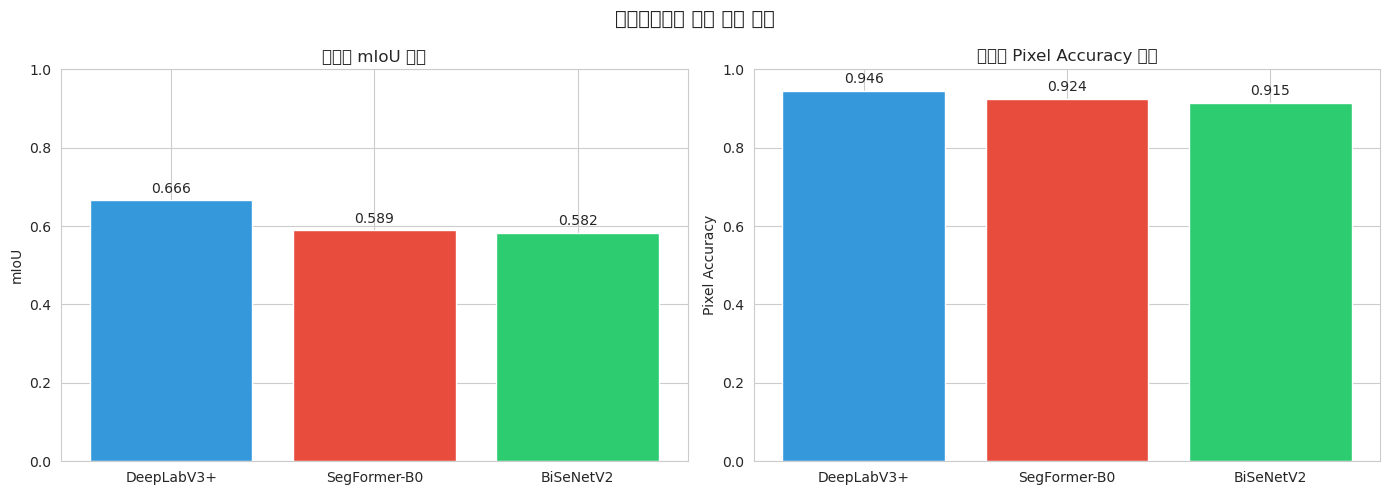

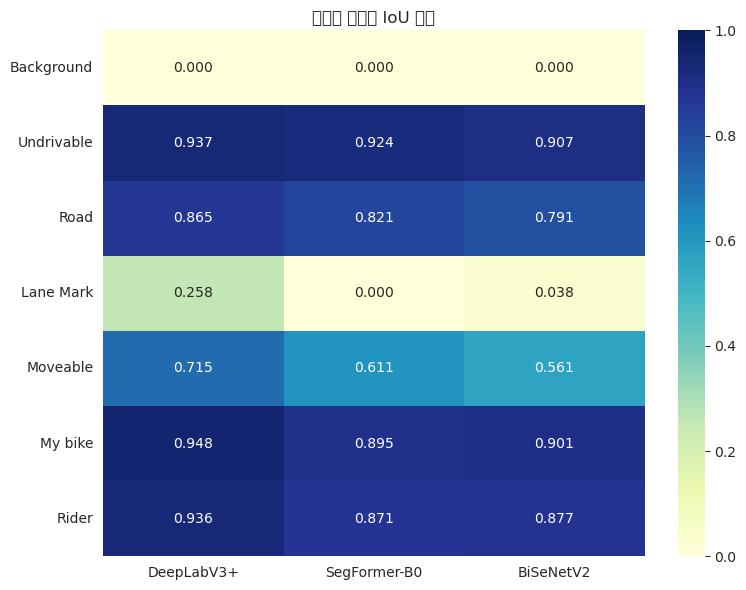


🏆 Best Model: DeepLabV3+ (mIoU=0.6657)


In [19]:
# ============================================================
# 3-5. 모델 비교 요약
# ============================================================
# 비교 테이블
comp_data = []
for name, res in all_results.items():
    comp_data.append({'Model': name, 'mIoU': res['miou'], 'Pixel Acc': res['pixel_acc']})
comp_df = pd.DataFrame(comp_data).sort_values('mIoU', ascending=False)
print('📊 모델 성능 비교:')
display(comp_df)

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
x = range(len(comp_df))
axes[0].bar(x, comp_df['mIoU'], color=['#3498db', '#e74c3c', '#2ecc71'][:len(comp_df)])
axes[0].set_xticks(x)
axes[0].set_xticklabels(comp_df['Model'])
axes[0].set_ylabel('mIoU')
axes[0].set_title('모델별 mIoU 비교')
axes[0].set_ylim(0, 1)
for i, v in enumerate(comp_df['mIoU']):
    axes[0].text(i, v + 0.02, f'{v:.3f}', ha='center')

axes[1].bar(x, comp_df['Pixel Acc'], color=['#3498db', '#e74c3c', '#2ecc71'][:len(comp_df)])
axes[1].set_xticks(x)
axes[1].set_xticklabels(comp_df['Model'])
axes[1].set_ylabel('Pixel Accuracy')
axes[1].set_title('모델별 Pixel Accuracy 비교')
axes[1].set_ylim(0, 1)
for i, v in enumerate(comp_df['Pixel Acc']):
    axes[1].text(i, v + 0.02, f'{v:.3f}', ha='center')

plt.suptitle('세그멘테이션 모델 성능 비교', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# 클래스별 IoU 비교 히트맵
iou_df = pd.DataFrame({name: res['iou_per_class'] for name, res in all_results.items()}, index=class_names)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(iou_df, annot=True, fmt='.3f', cmap='YlGnBu', ax=ax, vmin=0, vmax=1)
ax.set_title('모델별 클래스 IoU 비교')
plt.tight_layout()
plt.show()

# Best model 선택
best_name = comp_df.iloc[0]['Model']
best_model = all_results[best_name]['model']
best_type = all_results[best_name]['type']
print(f'\n🏆 Best Model: {best_name} (mIoU={all_results[best_name]["miou"]:.4f})')


---
# 4. 안전 점수 산출

Best 모델의 예측 마스크에서 클래스별 비율을 추출하여 **규칙 기반 안전 점수**를 산출합니다.

$$\text{safety} = 0.35 \times \text{Road} + 0.15 \times \text{Lanemark} - 0.25 \times \text{Undrivable} - 0.25 \times \text{Movable}$$


⏳ DeepLabV3+으로 안전 점수 산출 중...
✅ 안전 점수 산출 완료 (40장)

📊 안전 점수 통계:
count     40.0
mean      61.5
std       22.2
min        0.0
25%       53.8
50%       66.2
75%       75.8
max      100.0
Name: safety_score, dtype: float64

📊 등급 분포:
grade
Safe         20
Caution      15
Dangerous     5
Name: count, dtype: int64


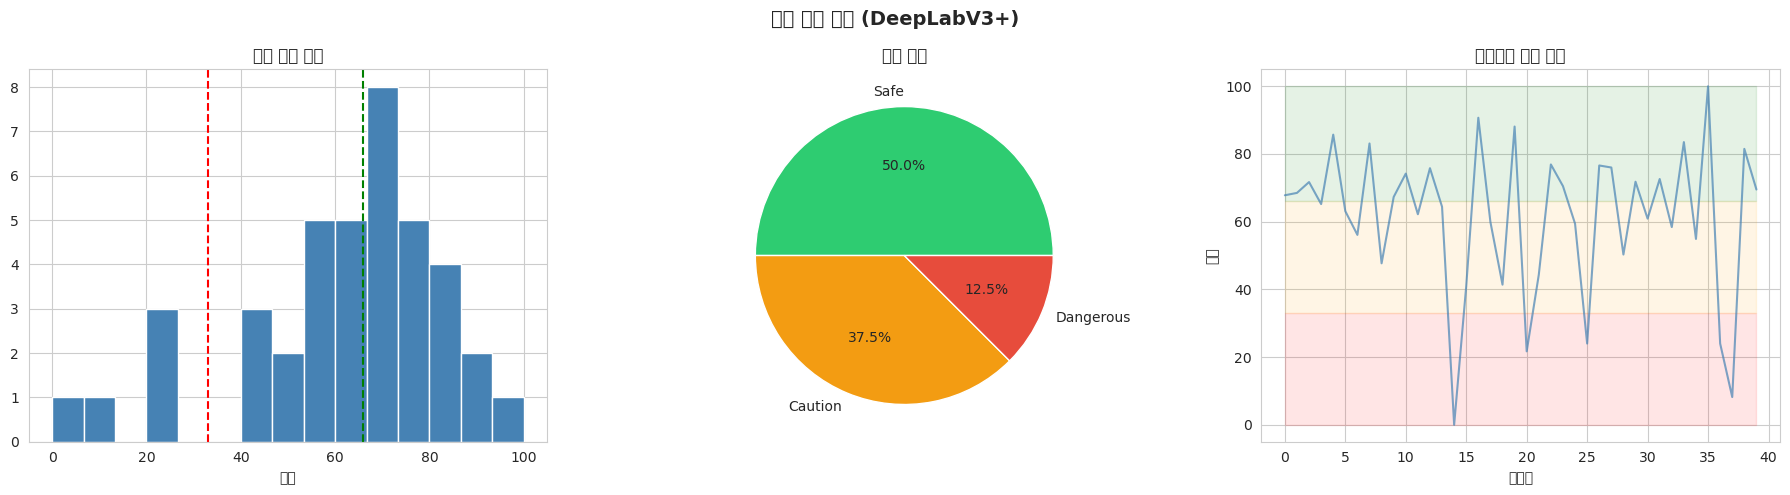

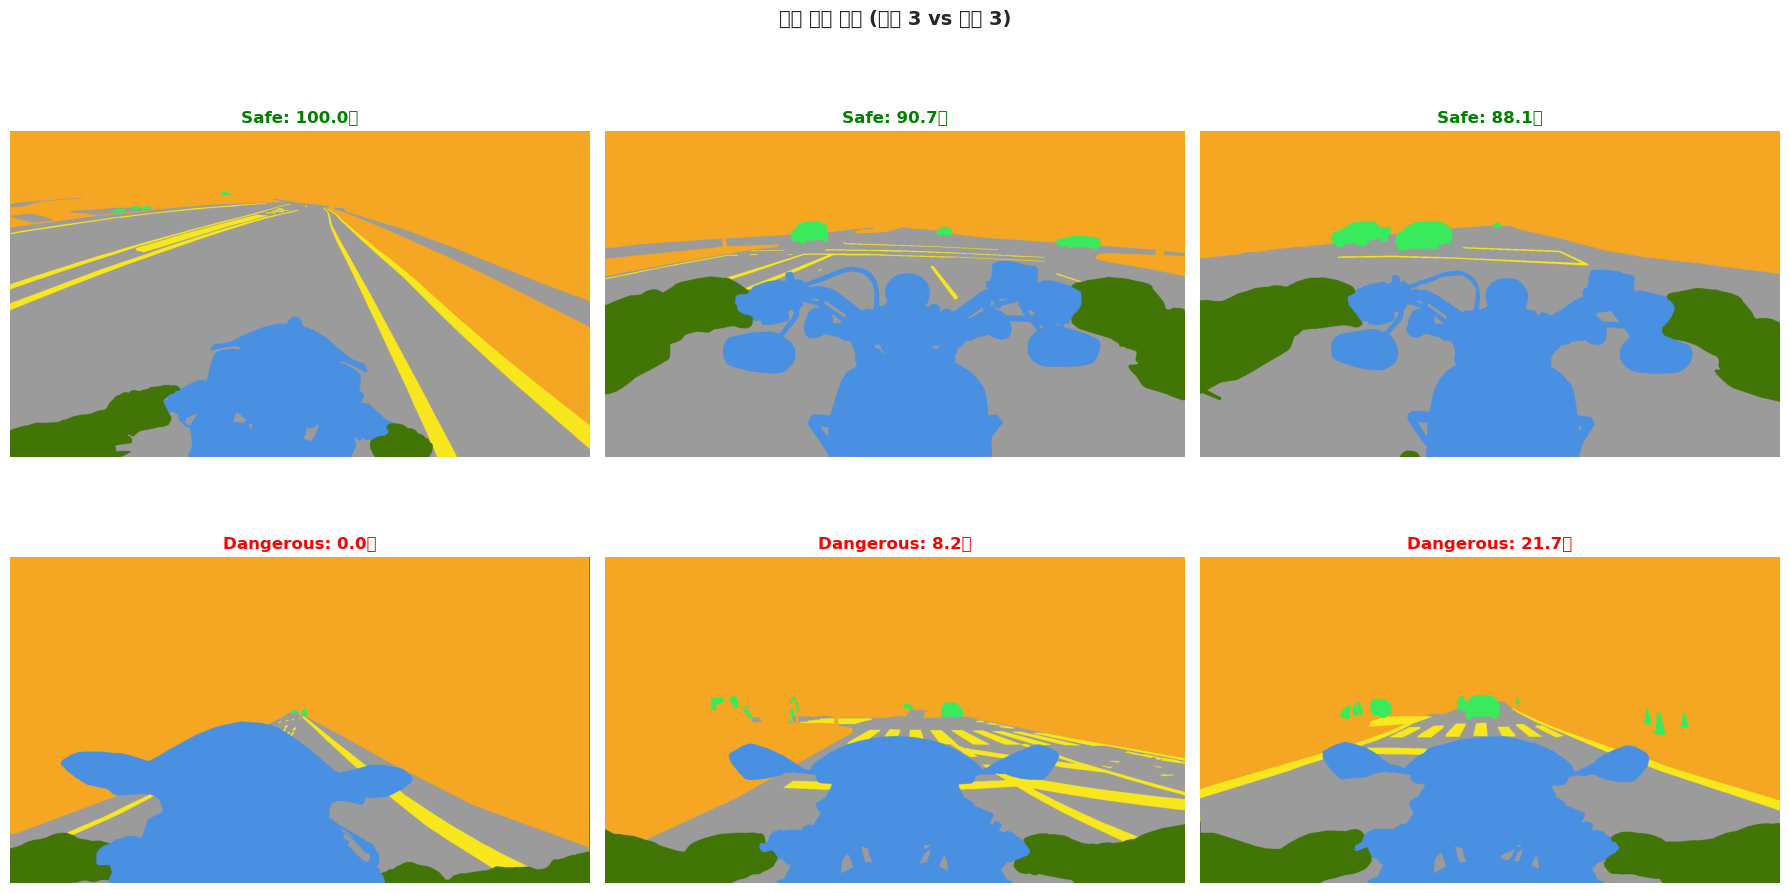

In [29]:
# ============================================================
# 4-1. 모델 예측 기반 안전 점수 산출
# ============================================================
# 클래스 이름 → 인덱스 매핑 (class_names 기반)
name_to_idx = {n: i for i, n in enumerate(class_names)}

def predict_mask(model, img_tensor, dev, model_type='standard'):
    """단일 이미지에 대한 예측 마스크 반환"""
    model.eval()
    with torch.no_grad():
        x = img_tensor.unsqueeze(0).to(dev)
        if model_type == 'segformer':
            logits = model(pixel_values=x).logits
            logits = F.interpolate(logits, size=img_tensor.shape[-2:], mode='bilinear', align_corners=False)
        else:
            out = model(x)
            logits = out['out'] if isinstance(out, dict) else out
    return logits.argmax(1).squeeze(0).cpu().numpy()

def compute_safety_from_mask(pred_mask, name_to_idx, class_names):
    """예측 마스크에서 안전 점수 산출"""
    total = pred_mask.size
    ratios = {}
    for name in class_names:
        idx = name_to_idx[name]
        ratios[name] = np.sum(pred_mask == idx) / total

    raw = (0.35 * ratios.get('Road', 0) +
           0.15 * ratios.get('Lanemark', 0) -
           0.25 * ratios.get('Undrivable', 0) -
           0.25 * ratios.get('Movable', 0))
    return raw, ratios

# 전체 Val 이미지에 대해 안전 점수 계산
print(f'⏳ {best_name}으로 안전 점수 산출 중...')
safety_records = []

for img_id in val_ids:
    info = coco.loadImgs(img_id)[0]
    img = np.array(Image.open(IMAGE_DIR + '/' + info['file_name']).convert('RGB'))
    t = val_transform(image=img)
    img_tensor = t['image'].float()
    pred = predict_mask(best_model, img_tensor, device, best_type)
    raw_score, ratios = compute_safety_from_mask(pred, name_to_idx, class_names)
    safety_records.append({'image_id': img_id, 'file_name': info['file_name'],
                           'safety_raw': raw_score, **ratios})

safety_df = pd.DataFrame(safety_records)

# MinMax 정규화 → 0~100
s_min, s_max = safety_df['safety_raw'].min(), safety_df['safety_raw'].max()
safety_df['safety_score'] = ((safety_df['safety_raw'] - s_min) / (s_max - s_min + 1e-10) * 100).round(1)
safety_df['grade'] = safety_df['safety_score'].apply(
    lambda s: 'Safe' if s >= 66 else ('Caution' if s >= 33 else 'Dangerous')
)

print(f'✅ 안전 점수 산출 완료 ({len(safety_df)}장)')
print(f'\n📊 안전 점수 통계:')
print(safety_df['safety_score'].describe().round(1))
print(f'\n📊 등급 분포:')
print(safety_df['grade'].value_counts())

# 시각화
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].hist(safety_df['safety_score'], bins=15, color='steelblue', edgecolor='white')
axes[0].axvline(33, color='red', linestyle='--')
axes[0].axvline(66, color='green', linestyle='--')
axes[0].set_title('안전 점수 분포')
axes[0].set_xlabel('점수')

grade_counts = safety_df['grade'].value_counts()
colors_pie = {'Safe': '#2ecc71', 'Caution': '#f39c12', 'Dangerous': '#e74c3c'}
axes[1].pie(grade_counts.values, labels=grade_counts.index,
            autopct='%1.1f%%', colors=[colors_pie.get(g, 'gray') for g in grade_counts.index])
axes[1].set_title('등급 분포')

axes[2].plot(range(len(safety_df)), safety_df['safety_score'].values, color='steelblue', alpha=0.7)
axes[2].fill_between(range(len(safety_df)), 0, 33, alpha=0.1, color='red')
axes[2].fill_between(range(len(safety_df)), 33, 66, alpha=0.1, color='orange')
axes[2].fill_between(range(len(safety_df)), 66, 100, alpha=0.1, color='green')
axes[2].set_title('프레임별 안전 점수')
axes[2].set_xlabel('프레임')
axes[2].set_ylabel('점수')

plt.suptitle(f'안전 점수 분석 ({best_name})', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Safe / Dangerous 대표 프레임 시각화
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
for i, (_, row) in enumerate(safety_df.nlargest(3, 'safety_score').iterrows()):
    fuse_p = IMAGE_DIR + '/' + (row['file_name'] + '___fuse.png')
    orig_p = IMAGE_DIR + '/' + row['file_name']
    # p = fuse_p if fuse_p.exists() else orig_p
    p = fuse_p if os.path.exists(fuse_p) else orig_p
    
    if os.path.exists(p):
        axes[0, i].imshow(Image.open(p))
    axes[0, i].set_title(f'Safe: {row["safety_score"]}점', color='green', fontweight='bold')
    axes[0, i].axis('off')

for i, (_, row) in enumerate(safety_df.nsmallest(3, 'safety_score').iterrows()):
    fuse_p = IMAGE_DIR + '/' + (row['file_name'] + '___fuse.png')
    orig_p = IMAGE_DIR + '/' + row['file_name']
    # p = fuse_p if fuse_p.exists() else orig_p
    p = fuse_p if os.path.exists(fuse_p) else orig_p
    
    # if p.exists():
    if os.path.exists(p):
        axes[1, i].imshow(Image.open(p))
    axes[1, i].set_title(f'Dangerous: {row["safety_score"]}점', color='red', fontweight='bold')
    axes[1, i].axis('off')

plt.suptitle('안전 등급 비교 (상위 3 vs 하위 3)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


---
# 5. GradCAM 시각화

**GradCAM** (Gradient-weighted Class Activation Mapping)을 통해 각 모델이 특정 클래스를 예측할 때 이미지의 **어느 영역에 주목**하는지 시각화합니다.
- 각 모델의 마지막 특징 추출 레이어에 GradCAM 적용
- Road, Movable, Undrivable 등 안전에 핵심적인 클래스를 대상으로 분석


In [ ]:
# ============================================================
# 5-1. GradCAM 시각화
# ============================================================
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import SemanticSegmentationTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# ---- 모델별 타겟 레이어 설정 ----
def get_target_layer(model, model_name):
    """각 모델의 GradCAM 타겟 레이어 반환"""
    if 'DeepLab' in model_name:
        return [model.backbone.layer4[-1]]
    elif 'SegFormer' in model_name:
        # SegFormer encoder의 마지막 블록
        return [model.segformer.encoder.block[-1][-1].output.dense]
    elif 'BiSeNet' in model_name:
        return [model.semantic.layer4[-1]]
    return []

# ---- GradCAM용 모델 래퍼 (SegFormer용) ----
class SegformerWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def forward(self, x):
        out = self.model(pixel_values=x)
        logits = out.logits
        return F.interpolate(logits, size=x.shape[-2:], mode='bilinear', align_corners=False)

# ---- 시각화 함수 ----
def denormalize(img_tensor):
    """ImageNet 정규화 역변환 → [0,1] numpy"""
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img_tensor.permute(1, 2, 0).cpu().numpy()
    img = img * std + mean
    return np.clip(img, 0, 1).astype(np.float32)

# 시각화 대상 클래스 (안전에 핵심적인 클래스)
target_class_names = ['Road', 'Movable', 'Undrivable']
target_class_ids = [name_to_idx.get(n, 0) for n in target_class_names if n in name_to_idx]
target_class_names = [n for n in target_class_names if n in name_to_idx]

# 샘플 이미지 3장 준비
sample_val_ids = val_ids[:3]
sample_tensors = []
sample_rgb = []
for img_id in sample_val_ids:
    info = coco.loadImgs(img_id)[0]
    img = np.array(Image.open(IMAGE_DIR / info['file_name']).convert('RGB'))
    t = val_transform(image=img)
    sample_tensors.append(t['image'].float())
    sample_rgb.append(denormalize(t['image'].float()))

# ---- 모델별 GradCAM 시각화 ----
for model_name, res in all_results.items():
    mdl = res['model']
    mtype = res['type']

    try:
        if mtype == 'segformer':
            wrapped = SegformerWrapper(mdl)
            target_layers = [mdl.segformer.encoder.block[-1][-1].output.dense]
            cam_model = wrapped
        else:
            target_layers = get_target_layer(mdl, model_name)
            cam_model = mdl

        cam_model.eval()
        cam = GradCAM(model=cam_model, target_layers=target_layers)

        n_classes_show = len(target_class_names)
        n_samples = len(sample_tensors)
        fig, axes = plt.subplots(n_samples, n_classes_show + 1, figsize=(5 * (n_classes_show + 1), 5 * n_samples))
        if n_samples == 1:
            axes = axes[np.newaxis, :]

        for si in range(n_samples):
            # 원본 이미지
            axes[si, 0].imshow(sample_rgb[si])
            axes[si, 0].set_title('원본', fontsize=10)
            axes[si, 0].axis('off')

            input_tensor = sample_tensors[si].unsqueeze(0)

            # 예측 마스크 얻기
            with torch.no_grad():
                if mtype == 'segformer':
                    pred = cam_model(input_tensor.to(device)).argmax(1).squeeze(0).cpu().numpy()
                else:
                    out = mdl(input_tensor.to(device))
                    logits = out['out'] if isinstance(out, dict) else out
                    pred = logits.argmax(1).squeeze(0).cpu().numpy()

            for ci, (cls_name, cls_id) in enumerate(zip(target_class_names, target_class_ids)):
                # 해당 클래스의 마스크 영역
                cls_mask = (pred == cls_id).astype(np.float32)
                if cls_mask.sum() < 10:
                    axes[si, ci + 1].imshow(sample_rgb[si])
                    axes[si, ci + 1].set_title(f'{cls_name}\n(미검출)', fontsize=10)
                    axes[si, ci + 1].axis('off')
                    continue

                targets = [SemanticSegmentationTarget(cls_id, torch.from_numpy(cls_mask))]
                grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]
                cam_image = show_cam_on_image(sample_rgb[si], grayscale_cam, use_rgb=True)

                axes[si, ci + 1].imshow(cam_image)
                axes[si, ci + 1].set_title(f'{cls_name}', fontsize=10)
                axes[si, ci + 1].axis('off')

        plt.suptitle(f'GradCAM: {model_name}', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
        print(f'✅ {model_name} GradCAM 완료')

    except Exception as e:
        print(f'⚠️ {model_name} GradCAM 실패: {e}')

print('\n📌 GradCAM 해석:')
print('  - 빨간 영역: 해당 클래스 예측에 가장 큰 영향을 미친 부분')
print('  - Road: 도로 표면 자체에 집중하는지 확인')
print('  - Movable: 차량/보행자 영역에 집중하는지 확인')
print('  - Undrivable: 인도/건물 등 비주행 영역에 집중하는지 확인')


---
# 6. 결론

## 6-1. 프로젝트 요약
- **데이터**: Motorcycle Night Ride 데이터셋 (~200장, 6클래스 세만틱 세그멘테이션)
- **모델**: DeepLabV3+, SegFormer-B0, BiSeNetV2 세 가지 세그멘테이션 모델을 fine-tuning
- **안전 점수**: 모델 예측 마스크의 클래스 비율 기반 규칙적 점수 산출
- **XAI**: GradCAM으로 모델의 클래스별 주목 영역 시각화

## 6-2. 주요 발견
1. **DeepLabV3+**: Atrous convolution 기반으로 다양한 스케일의 도로 장면을 포착. COCO pretrained의 이점
2. **SegFormer-B0**: Transformer 기반으로 전역 문맥(global context) 학습에 강점. 경량 구조
3. **BiSeNetV2**: Detail + Semantic 이중 경로로 공간 정보와 의미 정보를 동시에 학습
4. **GradCAM 분석**: 각 모델이 해당 클래스의 실제 영역에 집중하는지 정성적으로 확인

## 6-3. Metric 근거
- **mIoU**: 세그멘테이션의 표준 metric. 클래스별 예측-GT 겹침 비율의 평균
- **Pixel Accuracy**: 전체 픽셀 중 올바르게 분류된 비율
- **Safety Score**: 도메인 지식 기반 가중합 → 정량적 안전 평가

## 6-4. 한계 및 향후 과제
- **데이터 수 부족 (~200장)**: 더 큰 데이터셋(BDD100K, Cityscapes 등)과 결합 시 성능 향상 기대
- **야간 전용**: 주간/악천후 일반화를 위해 다양한 환경 데이터 필요
- **단일 프레임 분석**: 영상 시계열(temporal) 정보 활용 시 더 정교한 안전 평가 가능
- **GradCAM 한계**: 세그멘테이션에서는 CAM이 대략적인 영역만 보여줌 → Attention Map 직접 시각화도 보완 가능
